# Quora Question Pair Similarity 

## [ CONTENTS ] 

1. About the dataset<br>
2. Real-world/Business objectives and constraints<br>
3. Data and Libraries Loading<br>
4. Data Preprocessing <br>
4. Exploratory Data Analysis
5. Naive Bayes on k-Fold cross validation<br>
6. Bag of Words (BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
7. TF-IDF<br>
8. Summary<br>

## 1. About the dataset
1. **Title:** Quora Question Pairs. Link:https://www.kaggle.com/c/quora-question-pairs 
2. **Data:** Genuine questions from Quora.
3. **Task:** For a given pair of questions we need to predict if they are duplicate or not. 
4. **Relevant Info:** Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.<br>
<br>
5. **Data includes:** 
    * **id** - the id of a training set question pair
    * **qid1, qid2** - unique ids of each question (only available in train.csv)
    * **question1, question2** - the full text of each question
    * **is_duplicate** - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.<br>
<br>
6. **Data Overview:** 
    * Data will be in a file Train.csv
    * Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
    * Size of Train.csv - 60MB
    * Number of rows in Train.csv = 404,290 

## 2. Real-world/Business objective and constraints

**Objective:** It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. 
<br>
<br>**Constraints:**
<br>

* The cost of a mis-classification can be very high.
* You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
* No strict latency concerns.
* Interpretability is partially important.

## 3. Data and Libraries Loading

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import nltk 

In [2]:
data = pd.read_csv('train.csv')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  404290
Number of features :  6
Features :  ['id' 'qid1' 'qid2' 'question1' 'question2' 'is_duplicate']


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## 4. Exploratory Data Analysis (EDA)

### [A] Distribution of Classes

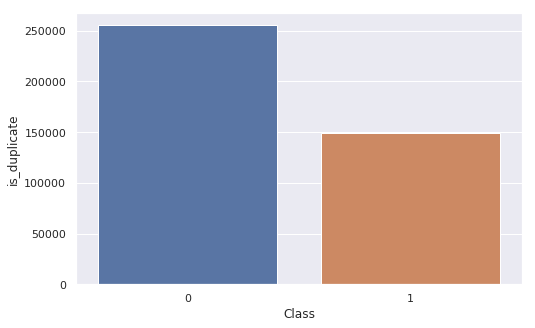

In [13]:
sns.set()
plt.figure(figsize = (8, 5))
plt.xlabel('Class')
sns.barplot(x = np.unique(data.is_duplicate), y = data.is_duplicate.value_counts(), alpha = 1)

#### Observation:
* There is more non-similar question pairs than similar pairs.

In [19]:
print('Similar question pair(is_duplicate = 1) rate is :', data.is_duplicate.value_counts()[1] / len(data))
print('Non-similar question pair (is_duplicate = 0) rate is :', data.is_duplicate.value_counts()[0] / len(data))

Similar question pair(is_duplicate = 1) rate is : 0.369197853026293
Non-similar question pair (is_duplicate = 0) rate is : 0.630802146973707


#### Observation:
* Only 37% of the question pairs are similar, whereas 63% are non similar.

### [B] Distribution of Questions

In [20]:
all_qs = pd.Series(data.qid1.tolist() + data.qid2.tolist())
unique_qs = len(np.unique(all_qs))
qs_more_than_one = np.sum(all_qs.value_counts() > 1)
max_repeated_q = all_qs.value_counts().max()
print('Number of Unique Questions are :', unique_qs)
print('Number of Questions that are asked more than once :', qs_more_than_one)
print('Maximum number of times a single question is repeated :', max_repeated_q)

Number of Unique Questions are : 537933
Number of Questions that are asked more than once : 111780
Maximum number of times a single question is repeated : 157


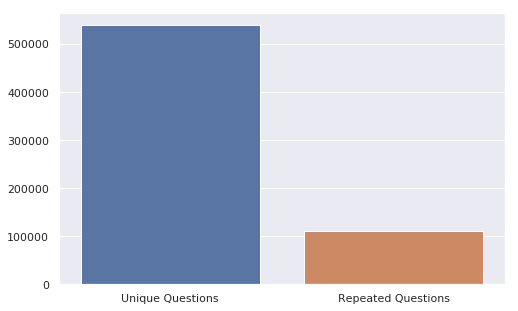

In [21]:
x = ['Unique Questions', 'Repeated Questions']
y = [unique_qs, qs_more_than_one]
plt.figure(figsize = (8, 5))
sns.barplot(x, y, alpha = 1)

#### Observation:
* The dataset contains more unique question than repeated ones.

In [34]:
pair_duplicate = data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print('Number of duplicate entries :', pair_duplicate.shape[0] - data.shape[0])

Number of duplicate entries : 0


Max appearence of a question is : 157


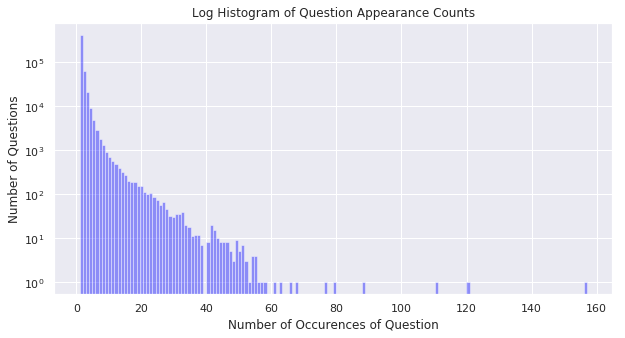

In [38]:
plt.figure(figsize = (10, 5))
sns.distplot(all_qs.value_counts(), kde = False, color = 'blue', bins = 160)
plt.yscale('log')
plt.xlabel('Number of Occurences of Question')
plt.ylabel('Number of Questions')
plt.title('Log Histogram of Question Appearance Counts')
print('Max appearence of a question is :', max_repeated_q)

#### Observation:
* Most questions are unique in this dataset.

### [C] Null Entry Check

In [40]:
nan_rows = data[data.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [41]:
data = data.dropna(axis = 0)

In [42]:
data.shape

(404287, 6)

#### Observation:
* The dataset contains 3 entries with NaN value in column question1 and question2. 
* And these 3 rows are removed as there is no scarcity of data.

## 5. Basic Feature Extraction